In [1]:
import logging
from utility import add_project_root_to_path

logging.basicConfig(level=logging.ERROR)

add_project_root_to_path()

In [2]:
from historical_data import get_historical_prices_for_two_assets
from datetime import datetime

stable_coin_symbol = "USDT"
A_symbol = "ETH"
B_symbol = "BTC"
interval = "5m"

start_time = datetime(2024, 11, 1, 12, 0, 0)
end_time = datetime(2024, 11, 10, 12, 0, 0)
historical_prices = get_historical_prices_for_two_assets(
    stable_coin_symbol, A_symbol, B_symbol, interval, start_time, end_time
)

historical_prices

A symbol candles count: 2593
B symbol candles count: 2593
Joined candles count: 2593


,time,price_A,price_B
0,2024-11-01 09:00:00,2501.03,69376.10
1,2024-11-01 09:05:00,2504.29,69432.00
2,2024-11-01 09:10:00,2504.00,69442.14
3,2024-11-01 09:15:00,2506.88,69483.99
4,2024-11-01 09:20:00,2503.44,69418.00
...,...,...,...
2588,2024-11-10 08:40:00,3182.23,78998.00
2589,2024-11-10 08:45:00,3170.84,78920.00
2590,2024-11-10 08:50:00,3180.72,79050.97
2591,2024-11-10 08:55:00,3182.99,79079.99


In [3]:
from user.informed_user import InformedUser
from user.uninformed_user import UninformedUser
from simulation.simulation import Simulation

informed_user = InformedUser()
uninformed_user = UninformedUser()

In [4]:
def get_initial_pool_sizes(price_A: float, price_B: float, total_pool: float) -> tuple:
    '''
    Returns the initial pool sizes for the two assets given the prices of the two assets
    '''
    r = price_A / price_B
    q_A = total_pool / (r + 1)
    q_B = total_pool - q_A
    return q_A, q_B

initial_quantity_A, initial_quantity_B = get_initial_pool_sizes(
    historical_prices["price_A"].iloc[0], historical_prices["price_B"].iloc[0], 100000
)

print(f"Initial quantity of A: {initial_quantity_A}, Initial quantity of B: {initial_quantity_B}")

Initial quantity of A: 96520.40920387334, Initial quantity of B: 3479.590796126664


In [5]:
from pool.simple_pool import SimplePool
from pool.abstract_pool import PoolLiquidityState

pool = SimplePool(
    liquidity_state=PoolLiquidityState(
        quantity_a=initial_quantity_A,
        quantity_b=initial_quantity_B
    ),
    alpha=0.001,
)

In [6]:
import numpy as np

np.random.seed(0)

simulation = Simulation(
    pool=pool,
    network_fee=0,
)

simulation_result = simulation.simulate(
    p_UU=0.5,
    informed_user=informed_user,
    uninformed_user=uninformed_user,
    prices=historical_prices,
)

In [7]:
simulation_result.snapshots[-1]

SimulationState(user_states={<UserType.INFORMED: 1>: ParticipantState(total_markout=272325.33656367345, position=Position(position_a=4197.564703140968, position_b=-160.67153595720393), valuation=645216.323484661), <UserType.UNINFORMED: 2>: ParticipantState(total_markout=-31642.390891432005, position=Position(position_a=942.3236958233069, position_b=-35.04532151546795), valuation=225899.94872934138)}, lp_state=ParticipantState(total_markout=-240682.94567224168, position=Position(position_a=91380.52080490948, position_b=3675.3076535993337), valuation=581655070.9207089), lp_with_just_hold_strategy=ParticipantState(total_markout=0, position=Position(position_a=96520.40920387334, position_b=3479.590796126664), valuation=582526187.1929219))

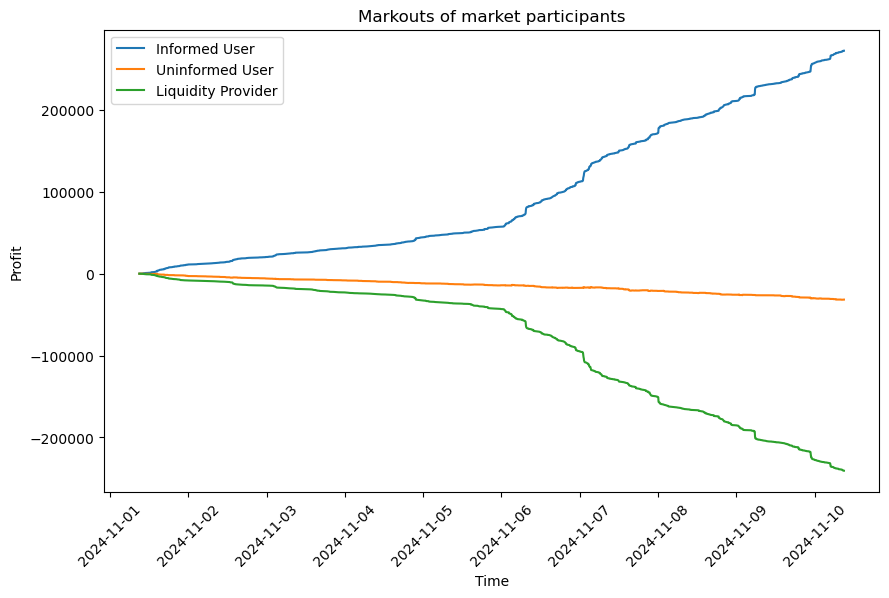

In [8]:
# Plot all participants' profits
import seaborn as sns
import matplotlib.pyplot as plt
from simulation.simulation import UserType, SimulationResult

fig, ax = plt.subplots(figsize=(10, 6))

def extract_user_markouts(
    simulation_result: SimulationResult, user_type: UserType
) -> list:
    res = []
    for snapshot in simulation_result.snapshots:
        res.append(snapshot.user_states[user_type].total_markout)
    return res
        
def extract_lp_markouts(simulation_result: SimulationResult) -> list:
    res = []
    for snapshot in simulation_result.snapshots:
        res.append(snapshot.lp_state.total_markout)
    return res

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_user_markouts(simulation_result, UserType.INFORMED),
    ax=ax,
    label="Informed User",
)

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_user_markouts(simulation_result, UserType.UNINFORMED),
    ax=ax,
    label="Uninformed User",
)


sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_lp_markouts(simulation_result),
    ax=ax,
    label="Liquidity Provider",
)

plt.xlabel("Time")
plt.ylabel("Profit")

plt.xticks(rotation=45)

plt.title("Markouts of market participants")

plt.show()

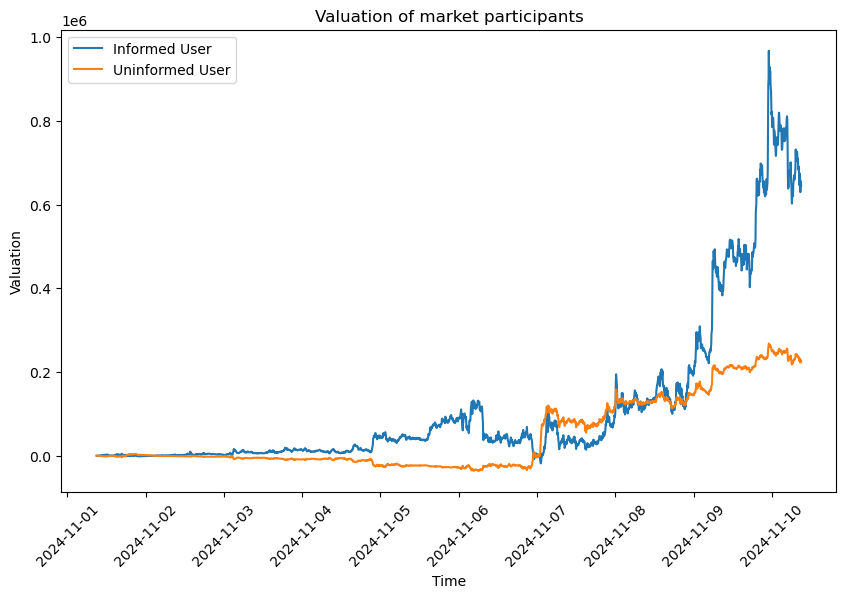

In [9]:
def extract_user_valuations(
    simulation_result: SimulationResult, user_type: UserType
) -> list:
    res = []
    for snapshot in simulation_result.snapshots:
        res.append(snapshot.user_states[user_type].valuation)
    return res
        

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_user_valuations(simulation_result, UserType.INFORMED),
    ax=ax,
    label="Informed User",
)

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_user_valuations(simulation_result, UserType.UNINFORMED),
    ax=ax,
    label="Uninformed User",
)

plt.xlabel("Time")
plt.ylabel("Valuation")


plt.xticks(rotation=45)

plt.title("Valuation of market participants")

plt.show()

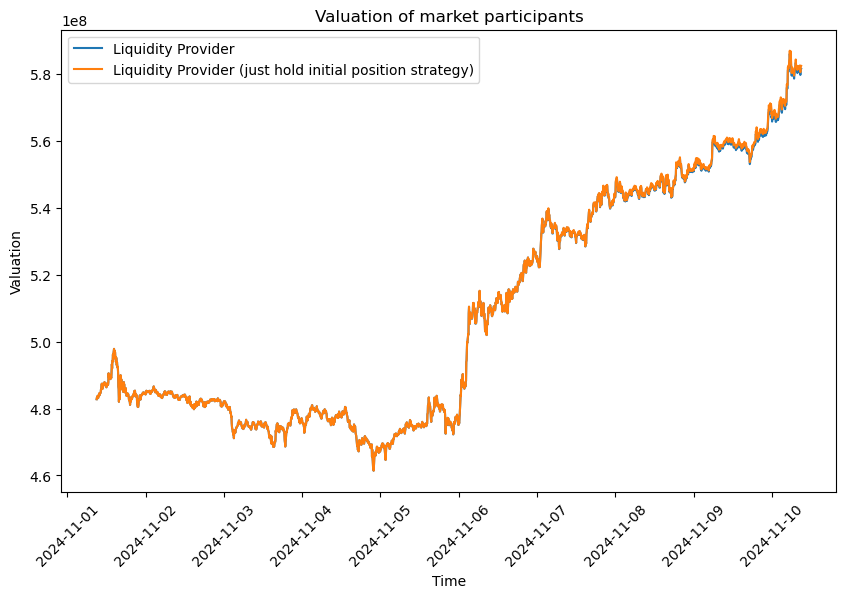

In [10]:
def extract_lp_valuations(
    simulation_result: SimulationResult
) -> list:
    res = []
    for snapshot in simulation_result.snapshots:
        res.append(snapshot.lp_state.valuation)
    return res

def extract_lp_only_hold_valuations(
    simulation_result: SimulationResult
) -> list:
    res = []
    for snapshot in simulation_result.snapshots:
        res.append(snapshot.lp_with_just_hold_strategy.valuation)
    return res

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_lp_valuations(simulation_result),
    ax=ax,
    label="Liquidity Provider",
)

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_lp_only_hold_valuations(simulation_result),
    ax=ax,
    label="Liquidity Provider (just hold initial position strategy)",
)

plt.xlabel("Time")
plt.ylabel("Valuation")

plt.xticks(rotation=45)

plt.title("Valuation of market participants")

plt.show()

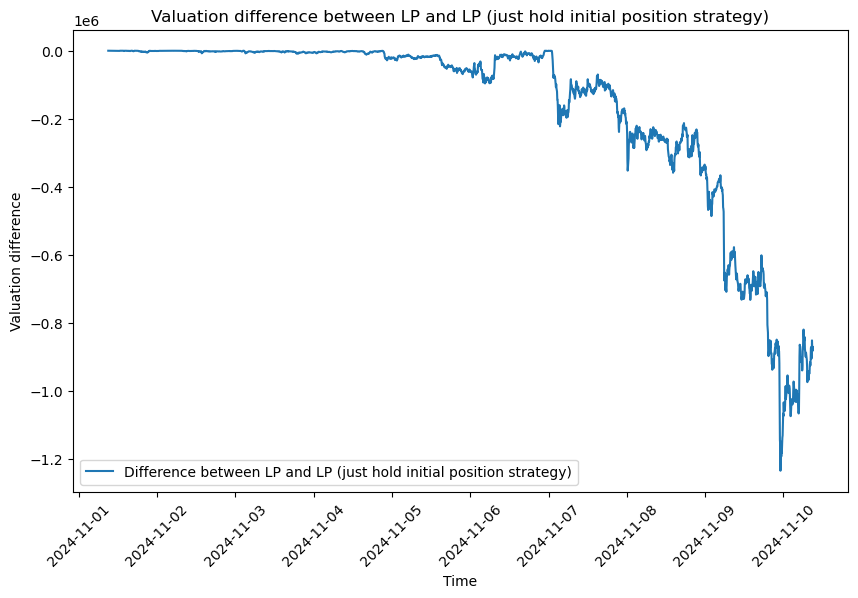

In [11]:
# Plot difference between two lp strategies

lp_valuations_diff = np.array(extract_lp_valuations(simulation_result)) - np.array(extract_lp_only_hold_valuations(simulation_result))

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    x=simulation_result.timestamps,
    y=lp_valuations_diff,
    ax=ax,
    label="Difference between LP and LP (just hold initial position strategy)",
)

plt.xlabel("Time")
plt.ylabel("Valuation difference")

plt.xticks(rotation=45)

plt.title("Valuation difference between LP and LP (just hold initial position strategy)")

plt.show()